<p><b><left>Verifying Zipf's law on Wikipedia English section</left></p></b>

Word count is one the basic tasks in Natural Language Processing (NLP). According to Zipf's Law:

<I>"For a given corpus of natural language utterance, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc."</I>- Wikipedia

To verify the theaory we need to find the most popular words in a relatively large natural language corpus. How about using the whole Wikipedia articles as the corpus! It seems to be a good fit for this purpose. Using Apache Spark we find the top 20 popular words in Wikipedia. 


In [1]:
from operator import add
from pyspark import SparkContext
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')

We first import all the packages we need to enable tab completion for actual code. We also need a helper function that will tokenize all the words in each line of text. There are few remarks here:

* We remove punctuations first by using translate method. Using translate is a little different for unicode and str characters. Since the characters are encoded with unicode in our case we use the unicode translate which takes only one argument which is a translation table or dictionary to map each character. String translate on the other hand takes two arguments with a seperate argument for deletewords. Ord() function will put unicode codes of the punctuations and will map them to None which will result is their removal.

* We also convert everything to lowercase cuz in our case it makes sense.

* Finally we split the words and return a list of all words

In [2]:
def my_tokenizer(s):
    return s.translate({ord(c):None for c in punctuation}).lower().split()

sc = SparkContext()
lines = sc.textFile(r'wiki\articles_in_plain_text.txt')
words = lines.flatMap(my_tokenizer)
words_count = words.map(lambda word: (word, 1)).reduceByKey(add)
top_20_words = words_count.map(lambda (a, b): (b, a)).sortByKey(ascending=False).take(20)
top_20_table = pd.DataFrame(top_20_words, columns=['Frequency', 'Words'])
top_20_table.set_index('Words', inplace=True)
top_20_table
    


,Frequency
Words,
the,136859109
of,67145625
and,56734911
in,54912806
a,40367328
to,38717907
was,22587671
is,19311992
for,16534120


The Spark code is very straightforward. 

* We build an RDD called lines which has all the articles of Wikipedia. Each article is in one line. 

* Using flapMap we apply my_tokenizer() to each line and flatten the result at the end. This gives us another RDD which includes all the words from all the lines in a list or array-like object. 

* To count the number of words we first need to assign a number to each word and then reduce them by key. The values will be all added to gether since we passed the add operator to reduceByKey() transformation. After this step we will have (word, count) pairs for every word in the document. 

* Since we want to sort them by value we have to swap key, value in each pair cuz Spark doesn't have sortbyvalue() transformation. We can only use sortbykey(). At the end of sort we take() the top 20 popular words. 

<strong>Notice:</strong> Spark operations are lazy. Only after calling take() which is an action, the code actually is going to run. Before that there was all references to those transformations. 

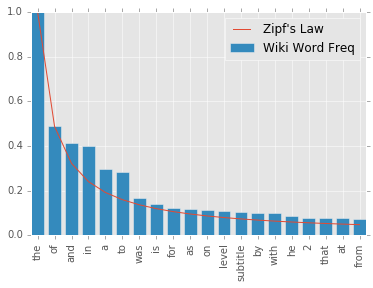

In [3]:
x = np.linspace(1, 21, num=20)
y = np.array([count[0] for count in top_20_words])/float(max([count[0] for count in top_20_words]))
plt.bar(x,y, align='center')
plt.xticks(x, [count[1] for count in top_20_words], rotation='vertical')
plt.plot(x, 1.0/x)
plt.legend(["Zipf's Law", 'Wiki Word Freq'])

After plotting the data, it can be seen that the Zipf's Law is kind of true for Wikipedia. 